<a href="https://colab.research.google.com/github/SSaiTeja23/INFO5731_Spring2020/blob/master/Copy_of_INFO5731_Assignment_Three.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **INFO5731 Assignment Four**

In this assignment, you are required to conduct topic modeling, sentiment analysis based on **the dataset you created from assignment three**.

# **Question 1: Topic Modeling**

(30 points). This question is designed to help you develop a feel for the way topic modeling works, the connection to the human meanings of documents. Based on the dataset from assignment three, write a python program to **identify the top 10 topics in the dataset**. Before answering this question, please review the materials in lesson 8, especially the code for LDA and LSA. The following information should be reported:

(1) Features (top n-gram phrases) used for topic modeling.

(2) Top 10 clusters for topic modeling.

(3) Summarize and describe the topic for each cluster. 


In [9]:
import nltk; nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [10]:
!python3 -m spacy download en

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')
✔ Linking successful
/usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
/usr/local/lib/python3.6/dist-packages/spacy/data/en
You can now load the model via spacy.load('en')


In [0]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

In [13]:
!pip install pyLDAvis

In [0]:
# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

In [0]:
# NLTK Stop words
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use'])

In [17]:
# Import Dataset
df = pd.read_csv('Tweets.csv')
print(df.Tweets.unique())
df.head()

[' COVID     Wuhan Coronovirus  Please stop using abbreviations to cover CCP s crime https   twitter com liuyun status   '
 ' ChinaVirus  chinazivirus  ChinaCoronaVirus  ChinaPneumonia  Wuhan Coronovirus  WuhanSARS  WuhanViruspic twitter com fXnBFBGh'
 ' crit en   The Eyes of Darkness de Dean Koontz suit un virus appel   Wuhan   d velopp  dans les laboratoires militaires de Wuhan  en  Chine    Wuhan Coronovirus https   twitter com reallygraceful status   '
 'Fall in new cases raises hope in virus outbreak in  China   https   apnews com cdfdceabdeaa      Wuhan Coronovirus'
 'Accelerate research and innovation  Mere buzz words that sound impressive to the masses  You re under influence of the Chinese government  And everyone knows it   shameonyou  wuhancoronov rus  China'
 'st case of  coronavirus confirmed in London   WHO  PHE London  CDCgov  coronavirusuk  outbreak  coronaviruschina  coronaviruswuhan  WuhanPneumonia  wuhancoronov rus  COVID  CoronavirusWho  pandemic  NotContained  Coro

,Tweet id,Tweets,Sentiments
0,0,COVID Wuhan Coronovirus Please stop usin...,Neutral
1,1,ChinaVirus chinazivirus ChinaCoronaVirus C...,Neutral
2,2,crit en The Eyes of Darkness de Dean Koontz...,Neutral
3,3,Fall in new cases raises hope in virus outbrea...,Neutral
4,4,Accelerate research and innovation Mere buzz ...,Positive


In [18]:
# Convert to list
data = df.Tweets.values.tolist()

# Remove Emails
data = [re.sub('\S*@\S*\s?', '', sent) for sent in data]

# Remove new line characters
data = [re.sub('\s+', ' ', sent) for sent in data]

# Remove distracting single quotes
data = [re.sub("\'", "", sent) for sent in data]

pprint(data[:1])

[' COVID Wuhan Coronovirus Please stop using abbreviations to cover CCP s '
 'crime https twitter com liuyun status ']


In [19]:
# def sent_to_words(sentences):
#     for sentence in sentences:
#         yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

# Tokenizing strings in list of strings 
res = [sub.split() for sub in data] 
# data_words = list(sent_to_words(data))

print(res)

[['COVID', 'Wuhan', 'Coronovirus', 'Please', 'stop', 'using', 'abbreviations', 'to', 'cover', 'CCP', 's', 'crime', 'https', 'twitter', 'com', 'liuyun', 'status'], ['ChinaVirus', 'chinazivirus', 'ChinaCoronaVirus', 'ChinaPneumonia', 'Wuhan', 'Coronovirus', 'WuhanSARS', 'WuhanViruspic', 'twitter', 'com', 'fXnBFBGh'], ['crit', 'en', 'The', 'Eyes', 'of', 'Darkness', 'de', 'Dean', 'Koontz', 'suit', 'un', 'virus', 'appel', 'Wuhan', 'd', 'velopp', 'dans', 'les', 'laboratoires', 'militaires', 'de', 'Wuhan', 'en', 'Chine', 'Wuhan', 'Coronovirus', 'https', 'twitter', 'com', 'reallygraceful', 'status'], ['Fall', 'in', 'new', 'cases', 'raises', 'hope', 'in', 'virus', 'outbreak', 'in', 'China', 'https', 'apnews', 'com', 'cdfdceabdeaa', 'Wuhan', 'Coronovirus'], ['Accelerate', 'research', 'and', 'innovation', 'Mere', 'buzz', 'words', 'that', 'sound', 'impressive', 'to', 'the', 'masses', 'You', 're', 'under', 'influence', 'of', 'the', 'Chinese', 'government', 'And', 'everyone', 'knows', 'it', 'shameon

In [20]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(res, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[res], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)


/usr/local/lib/python3.6/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


In [0]:
# Define functions for stopwords, bigrams, trigrams and lemmatization

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]



In [41]:
# Form Bigrams
data_words_bigrams = make_bigrams(res)
data_words_bigrams

[['COVID',
  'Wuhan',
  'Coronovirus',
  'Please',
  'stop',
  'using',
  'abbreviations',
  'to',
  'cover',
  'CCP',
  's',
  'crime',
  'https',
  'twitter',
  'com',
  'liuyun',
  'status'],
 ['ChinaVirus',
  'chinazivirus',
  'ChinaCoronaVirus',
  'ChinaPneumonia',
  'Wuhan',
  'Coronovirus',
  'WuhanSARS',
  'WuhanViruspic',
  'twitter',
  'com',
  'fXnBFBGh'],
 ['crit',
  'en',
  'The',
  'Eyes',
  'of',
  'Darkness',
  'de',
  'Dean',
  'Koontz',
  'suit',
  'un',
  'virus',
  'appel',
  'Wuhan',
  'd',
  'velopp',
  'dans',
  'les',
  'laboratoires',
  'militaires',
  'de',
  'Wuhan',
  'en',
  'Chine',
  'Wuhan',
  'Coronovirus',
  'https',
  'twitter',
  'com',
  'reallygraceful',
  'status'],
 ['Fall',
  'in',
  'new',
  'cases',
  'raises',
  'hope',
  'in',
  'virus',
  'outbreak',
  'in',
  'China',
  'https',
  'apnews',
  'com',
  'cdfdceabdeaa',
  'Wuhan',
  'Coronovirus'],
 ['Accelerate',
  'research',
  'and',
  'innovation',
  'Mere',
  'buzz',
  'words',
  'that',

In [42]:
from collections import Counter

bigram_counts = Counter()
for cell in data_words_bigrams:
    for bigram in cell:
        bigram_counts[bigram] += 1

bigram_counts.most_common(5)

[('WuhanCoronovirus', 81),
 ('com', 73),
 ('twitter', 58),
 ('https', 41),
 ('Wuhan', 35)]

In [43]:
# Create Dictionary
id2word = corpora.Dictionary(res)

# Create Corpus
texts = res

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1)]]


In [44]:
id2word[15]

'twitter'

In [0]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto')

In [47]:
# Top 10
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.034*"WuhanCoronovirus" + 0.031*"com" + 0.026*"twitter" + 0.024*"https" + '
  '0.019*"status" + 0.017*"to" + 0.012*"Wuhan" + 0.007*"you" + 0.007*"s" + '
  '0.007*"China"'),
 (1,
  '0.026*"WuhanCoronovirus" + 0.024*"com" + 0.019*"the" + 0.018*"twitter" + '
  '0.018*"https" + 0.015*"coronavirus" + 0.013*"in" + 0.013*"status" + '
  '0.011*"of" + 0.010*"and"'),
 (2,
  '0.042*"WuhanCoronovirus" + 0.031*"com" + 0.028*"twitter" + 0.017*"of" + '
  '0.011*"the" + 0.011*"coronavirus" + 0.011*"https" + 0.009*"status" + '
  '0.009*"pic" + 0.009*"all"'),
 (3,
  '0.026*"Wuhan" + 0.026*"WuhanCoronovirus" + 0.026*"com" + 0.021*"twitter" + '
  '0.019*"https" + 0.016*"the" + 0.014*"status" + 0.012*"to" + 0.010*"of" + '
  '0.009*"HK"'),
 (4,
  '0.024*"WuhanCoronovirus" + 0.015*"com" + 0.015*"pic" + 0.015*"twitter" + '
  '0.015*"a" + 0.015*"Wuhan" + 0.010*"jt" + 0.010*"mereka" + 0.010*"be" + '
  '0.010*"https"'),
 (5,
  '0.018*"to" + 0.015*"WuhanCoronovirus" + 0.011*"of" + 0.011*"the" + '
  '0.01

In [33]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=res, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.020332839196563

Coherence Score:  0.337545269139785


In [34]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1     -0.085443  0.062145       1        1  22.767149
3      0.137409  0.010155       2        1  14.091680
0      0.007216  0.077387       3        1  13.491543
2     -0.007321  0.089499       4        1  10.864898
9     -0.043206  0.019000       5        1   8.928381
8      0.086369 -0.044459       6        1   8.864684
5     -0.063650 -0.126621       7        1   7.475001
7     -0.032150 -0.022149       8        1   6.744626
4     -0.002214 -0.018197       9        1   4.343400
6      0.002990 -0.046760      10        1   2.428632, topic_info=            Term       Freq      Total Category  logprob  loglift
4          Wuhan  24.000000  24.000000  Default  30.0000  30.0000
2    Coronovirus  10.000000  10.000000  Default  29.0000  29.0000
15       twitter  40.000000  40.000000  Default  28.0000  28.0000
327         yang   6.000000   6.000000  Default  27.0000  27.0000
51            in  21.000000  21.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
597         cina   0.355797   1.659187  Topic10  -5.0271   2.1781
147          for   0.355797   6.057840  Topic10  -5.0271   0.8831
457     infected   0.355797   2.344337  Topic10  -5.0271   1.8324
138          are   0.355797   7.707956  Topic10  -5.0271   0.6422
63    government   0.355797   2.344762  Topic10  -5.0271   1.8323

[610 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
883       5  0.800121           A
1132      6  0.802286       Acaba
189       7  0.562336         All
189       8  0.562336         All
1078      4  0.509047  BArEAdiYpc
...     ...       ...         ...
122       5  0.191370       youtu
122       9  0.191370       youtu
400       5  0.800121     youtube
429       8  0.570312          yr
123       9  0.931512   zUlwKdBBY

[693 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 4, 1, 3, 10, 9, 6, 8, 5, 7])

3 --Summarize and describe the topic for each cluster.

There are 10 topics which are extracted,
In topic[0] : The word WuhanCoronovirus has been the most probabilistic word, also the words twitter and com.

In topic[1] : Again the word WuhanCoronovirus has been the most probabilistic word.

In topic[2] : The word WuhanCoronovirus has been 42percent being the most probabilistic word.

In Topic[3] : The words Wuhan and WuhanCoronovirus are the words which are most relevant to the topic.

It could be seen that mostly all the topics have the word WuhanCoronovirus as the word which is most relevant to the topic or the most probabilistic word relevant to topic.

---






# **Question 2: Sentiment Analysis**

(30 points). Sentiment analysis also known as opinion mining is a sub field within Natural Language Processing (NLP) that builds machine learning algorithms to classify a text according to the sentimental polarities of opinions it contains, e.g., positive, negative, neutral. The purpose of this question is to develop a machine learning classifier for sentiment analysis. Based on the dataset from assignment three, write a python program to implement a sentiment classifier and evaluate its performance. Notice: **80% data for training and 20% data for testing**.  

(1) Features used for sentiment classification and explain why you select these features.

(2) Select two of the supervised learning algorithm from scikit-learn library: https://scikit-learn.org/stable/supervised_learning.html#supervised-learning, to build a sentiment classifier respectively. 

(3) Compare the performance over accuracy, precision, recall, and F1 score for the two algorithms you selected. Here is the reference of how to calculate these metrics: https://towardsdatascience.com/accuracy-precision-recall-or-f1-331fb37c5cb9. 

In [0]:
Data = df.drop(columns=['Tweet id'])
data1 = Data['Tweets'].tolist()


In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Data['Tweets'], Data['Sentiments'], random_state=1)

In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer
corpus = data1
vectorizer = TfidfVectorizer(max_features=100)
X_train_vectorizer = vectorizer.fit_transform(X_train)
X_test_vectorizer = vectorizer.fit_transform(X_test)
# print(vectorizer.get_feature_names())  
# print(X.shape)

In [0]:
from sklearn.naive_bayes import MultinomialNB
naive_bayes = MultinomialNB()
naive_bayes.fit(X_train_vectorizer, y_train) 
predictions = naive_bayes.predict(X_test_vectorizer)

In [48]:
from sklearn.metrics import accuracy_score, precision_score, recall_score,classification_report

print(classification_report(y_test, predictions, target_names=['p','neg','neu']))


              precision    recall  f1-score   support

           p       0.00      0.00      0.00         2
         neg       0.80      1.00      0.89        20
         neu       0.00      0.00      0.00         3

    accuracy                           0.80        25
   macro avg       0.27      0.33      0.30        25
weighted avg       0.64      0.80      0.71        25



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [0]:
# !pip install sklearn.dataset

In [49]:
# Classifier - Algorithm - SVM
from sklearn import model_selection, naive_bayes, svm

SVM = svm.SVC(C=1.0, kernel='linear', degree=3, gamma='auto')
SVM.fit(X_train_vectorizer,y_train)
# predict the labels on validation dataset
predictions_SVM = SVM.predict(X_test_vectorizer)
# Use accuracy_score function to get the accuracy
print("SVM Accuracy Score -> ",accuracy_score(predictions_SVM, y_test)*100)

SVM Accuracy Score ->  80.0


In [50]:
from sklearn.datasets import make_classification

from sklearn.metrics import f1_score


print("precision_score:", precision_score(y_test, predictions_SVM, average='macro'))
print("recall_score:", recall_score(y_test, predictions_SVM, average='macro'))
print("f1_score:", f1_score(y_test, predictions_SVM, average='macro'))


precision_score: 0.26666666666666666
recall_score: 0.3333333333333333
f1_score: 0.29629629629629634


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


It could be observed that both the models, Naive Bayes and SVM are giving out the same accuracy percantage of 80.

Precision - Precision is the ratio of correctly predicted positive observations to the total predicted positive observations. High precision relates to the low false positive rate. We have got 0.26 precision which is pretty low.

Precision = TP/TP+FP

Recall (Sensitivity) - Recall is the ratio of correctly predicted positive observations to the all observations in actual class - yes. We have got recall of 0.33

Recall = TP/TP+FN

F1 score - F1 Score is the weighted average of Precision and Recall. Therefore, this score takes both false positives and false negatives into account. Intuitively it is not as easy to understand as accuracy, but F1 is usually more useful than accuracy, especially if you have an uneven class distribution. Accuracy works best if false positives and false negatives have similar cost. If the cost of false positives and false negatives are very different, it’s better to look at both Precision and Recall. In our case, F1 score is 0.296.

# **Question 3: House price prediction**

(40 points). You are required to build a **regression** model to predict the house price with 79 explanatory variables describing (almost) every aspect of residential homes. The purpose of this question is to practice regression analysis, an supervised learning model. The training data, testing data, and data description files can be download here: https://github.com/unt-iialab/INFO5731_Spring2020/blob/master/Assignments/assignment4-question3-data.zip. Here is an axample for implementation: https://towardsdatascience.com/linear-regression-in-python-predict-the-bay-areas-home-price-5c91c8378878. 


In [0]:
import pandas as pd
sf_train = pd.read_csv('train.csv')
sf_test = pd.read_csv('test.csv')

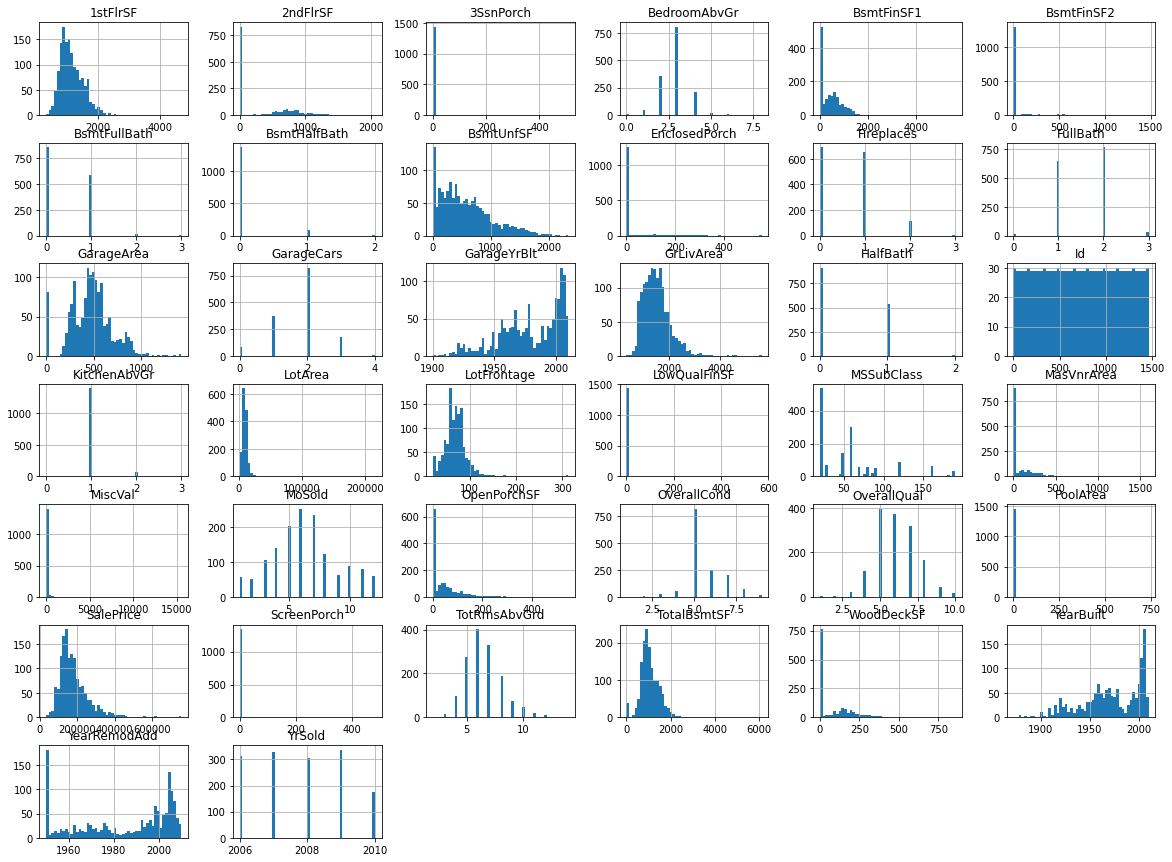

In [53]:
%matplotlib inline
import matplotlib.pyplot as plt
sf_train.hist(bins=50, figsize=(20,15))
plt.savefig("attribute_histogram_plots")
plt.show()

In [54]:
corr_matrix = sf_train.corr()
corr_matrix["SalePrice"].sort_values(ascending=False)

SalePrice        1.000000
OverallQual      0.790982
GrLivArea        0.708624
GarageCars       0.640409
GarageArea       0.623431
TotalBsmtSF      0.613581
1stFlrSF         0.605852
FullBath         0.560664
TotRmsAbvGrd     0.533723
YearBuilt        0.522897
YearRemodAdd     0.507101
GarageYrBlt      0.486362
MasVnrArea       0.477493
Fireplaces       0.466929
BsmtFinSF1       0.386420
LotFrontage      0.351799
WoodDeckSF       0.324413
2ndFlrSF         0.319334
OpenPorchSF      0.315856
HalfBath         0.284108
LotArea          0.263843
BsmtFullBath     0.227122
BsmtUnfSF        0.214479
BedroomAbvGr     0.168213
ScreenPorch      0.111447
PoolArea         0.092404
MoSold           0.046432
3SsnPorch        0.044584
BsmtFinSF2      -0.011378
BsmtHalfBath    -0.016844
MiscVal         -0.021190
Id              -0.021917
LowQualFinSF    -0.025606
YrSold          -0.028923
OverallCond     -0.077856
MSSubClass      -0.084284
EnclosedPorch   -0.128578
KitchenAbvGr    -0.135907
Name: SalePr

The SalePrice tends to increase when the OverallQual, GrLivArea and the GarageCars go up. You can see a small negative correlation between the EnclosedPorch and the KitchenAbvGr. And finally, coefficients close to zero indicate that there is no linear correlation.

We are now going to visualize the correlation between variables by using Pandas’ scatter_matrix function. We will just focus on a few promising variables, that seem the most correlated with the last SalePrice.

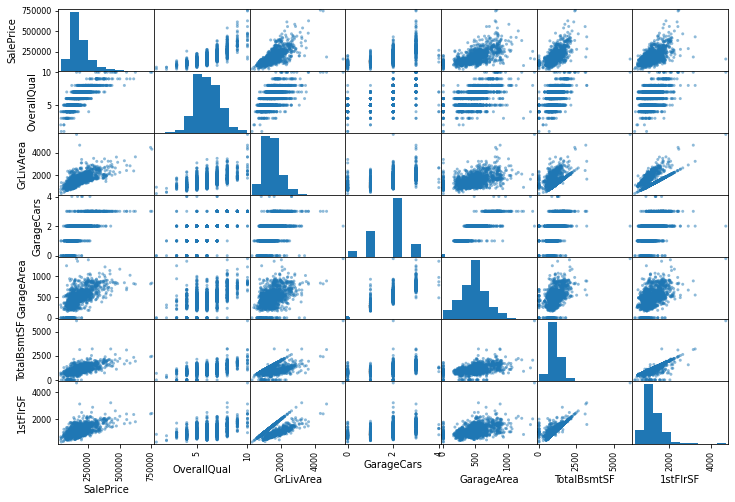

In [55]:
from pandas.plotting import scatter_matrix
attributes = ["SalePrice", "OverallQual", "GrLivArea", "GarageCars", "GarageArea", "TotalBsmtSF", "1stFlrSF"]
scatter_matrix(sf_train[attributes], figsize=(12, 8))
plt.savefig('matrix.png')

The most promising variable for predicting the SalePrice is the OverallQual, so let’s zoom in on their correlation scatter plot.

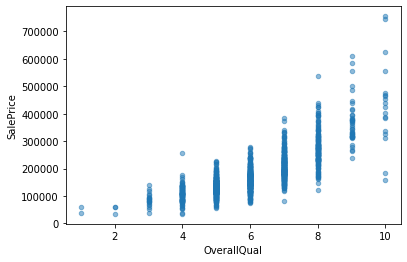

In [56]:
sf_train.plot(kind="scatter", x="OverallQual", y="SalePrice", alpha=0.5)
plt.savefig('scatter.png')

The correlation is indeed very strong; you can clearly see the upward trend and that the points are not too dispersed.

In [0]:
# X_train_set = sf_train.drop()
# sf_train.drop(sf_train.columns[[0,6,]], axis=1, inplace=True)
# sf_train.drop(['Id','BsmtFinSF2','Alley'],axis=1)
X_Train = sf_train[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF','HalfBath','LotArea','BsmtFullBath','BsmtUnfSF','BedroomAbvGr','ScreenPorch','PoolArea','MoSold','3SsnPorch']]
X_Train=X_Train.fillna(X_Train.mean())
Y_Train = sf_train['SalePrice']
Y_Train=Y_Train.fillna(Y_Train.mean())
X_Test = sf_test[['OverallQual','GrLivArea','GarageCars','GarageArea','TotalBsmtSF','1stFlrSF','FullBath','TotRmsAbvGrd','YearBuilt','YearRemodAdd','GarageYrBlt','MasVnrArea','Fireplaces','BsmtFinSF1','LotFrontage','WoodDeckSF','2ndFlrSF','OpenPorchSF','HalfBath','LotArea','BsmtFullBath','BsmtUnfSF','BedroomAbvGr','ScreenPorch','PoolArea','MoSold','3SsnPorch']]
X_Test = X_Test.fillna(X_Test.mean())

In [0]:
# X_Train.replace('NaN',0)

In [61]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_Train, Y_Train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

Done! We now have a working Linear Regression model

In [63]:
print('Linear Regression R squared": %.4f' % regressor.score(X_Train, Y_Train))

Linear Regression R squared": 0.8005


So, in our model, 80.05% of the variability in Y can be explained using X. 